# Time Series Analysis of Electrecity Production


In [1]:
# Install required packages if needed
# install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
#                   "lubridate", "gridExtra", "MASS", "knitr", "lawstat",
#                   "FinTS", "ggthemes"))


In [2]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(forecast)
  library(tseries)
  library(dplyr)
  library(lubridate)
  library(gridExtra)
  library(MASS)
  library(knitr)
  library(lawstat)
  library(FinTS)
  library(TSA)
})


In [ ]:
# Plot settings
options(repr.plot.width = 20, repr.plot.height = 10)
theme_tsa <- function() {
  theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "bottom",
      panel.grid.minor = element_line(color = "gray90"),
      panel.grid.major = element_line(color = "gray85")
    )
}

In [6]:
# loading the data and checking it for missing values
# and summary statistics, then printing the results

power_df <- read.csv("../data/electric_power_production.csv")
power_df$date <- as.Date(power_df$date)

cat("Dataset summary:\n")
print(summary(power_df))

cat(
    "\nDate range:", format(min(power_df$date), "%Y-%m-%d"),
    "to", format(max(power_df$date), "%Y-%m-%d"), "\n"
)

cat(
    "Index range:", min(power_df$value),
    "to", max(power_df$value), "\n"
)

missing_values <- colSums(is.na(power_df))
cat("\nMissing values by column:\n")
print(missing_values)

Dataset summary:
      date                value        
 Min.   :1939-01-01   Min.   :  3.334  
 1st Qu.:1960-07-08   1st Qu.: 21.134  
 Median :1982-01-16   Median : 57.064  
 Mean   :1982-01-15   Mean   : 57.047  
 3rd Qu.:2003-07-24   3rd Qu.: 89.718  
 Max.   :2025-02-01   Max.   :134.395  

Date range: 1939-01-01 to 2025-02-01 
Index range: 3.3336 to 134.3955 

Missing values by column:
 date value 
    0     0 


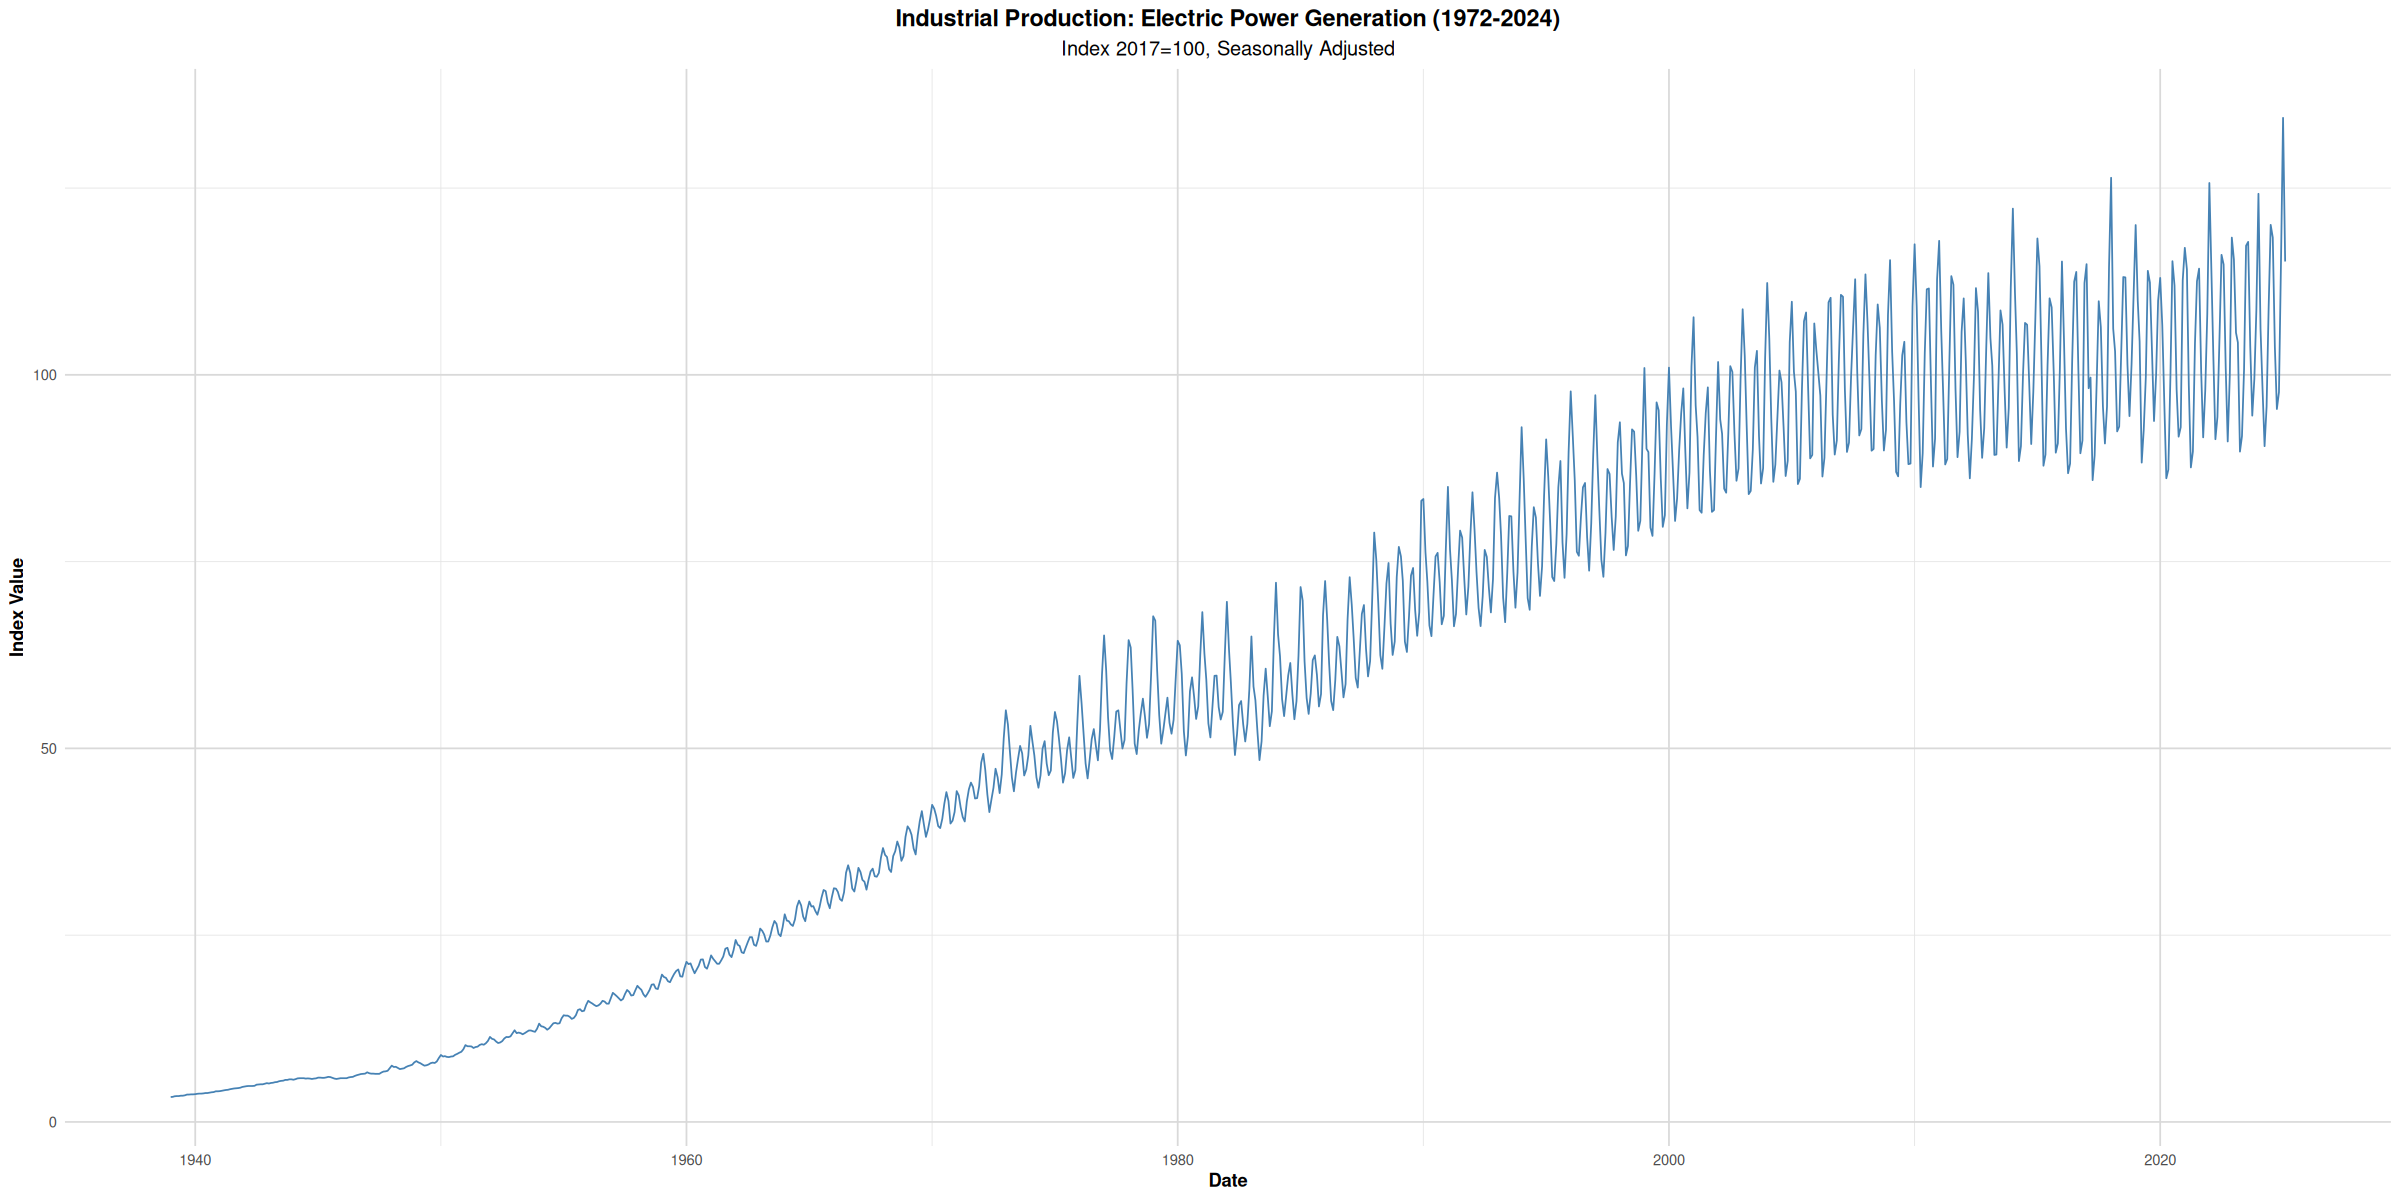

In [7]:
# plot the series

p1 <- ggplot(power_df, aes(x = date, y = value)) +
  geom_line(color = "#4682B4") +
  labs(
    title = "Industrial Production: Electric Power Generation (1972-2024)",
    subtitle = "Index 2017=100, Seasonally Adjusted",
    x = "Date",
    y = "Index Value"
  ) +
  theme_tsa()

print(p1)

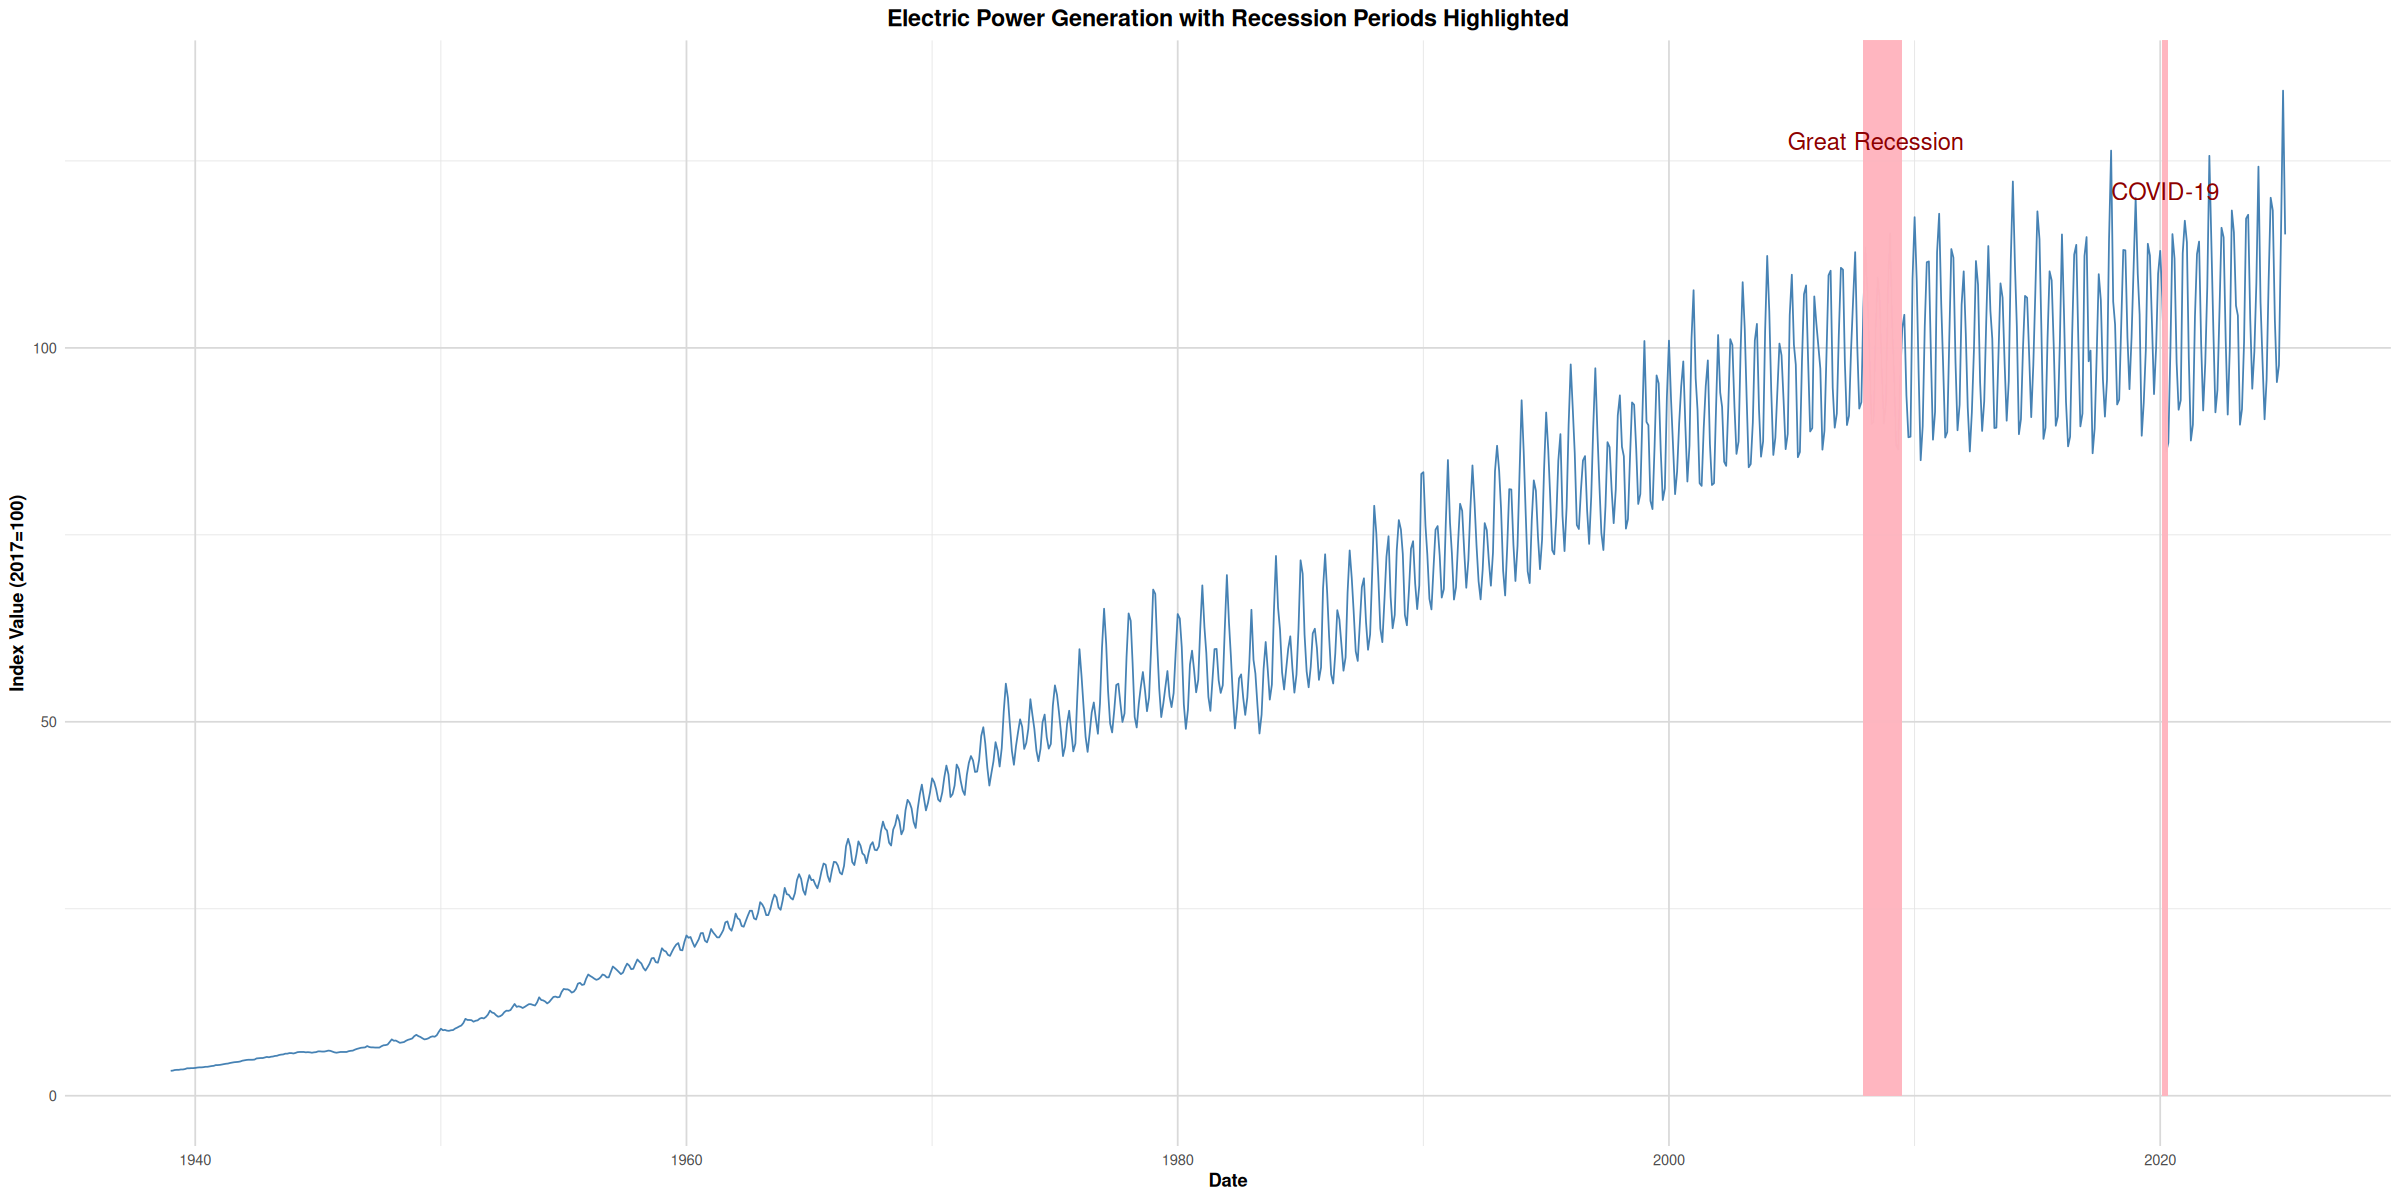

In [8]:
# Highlight recession periods
p2 <- ggplot(power_df, aes(x = date, y = value)) +
  geom_line(color = "#4682B4") +
  geom_rect(
    aes(
      xmin = as.Date("2007-12-01"),
      xmax = as.Date("2009-06-30"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightpink", alpha = 0.2
  ) +
  geom_rect(
    aes(
      xmin = as.Date("2020-02-01"),
      xmax = as.Date("2020-04-30"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightpink", alpha = 0.2
  ) +
  annotate("text",
    x = as.Date("2008-06-01"), y = max(power_df$value) * 0.95,
    label = "Great Recession", color = "darkred", size = 5
  ) +
  annotate("text",
    x = as.Date("2020-03-15"), y = max(power_df$value) * 0.9,
    label = "COVID-19", color = "darkred", size = 5
  ) +
  labs(
    title = "Electric Power Generation with Recession Periods Highlighted",
    x = "Date",
    y = "Index Value (2017=100)"
  ) +
  theme_tsa()

print(p2)

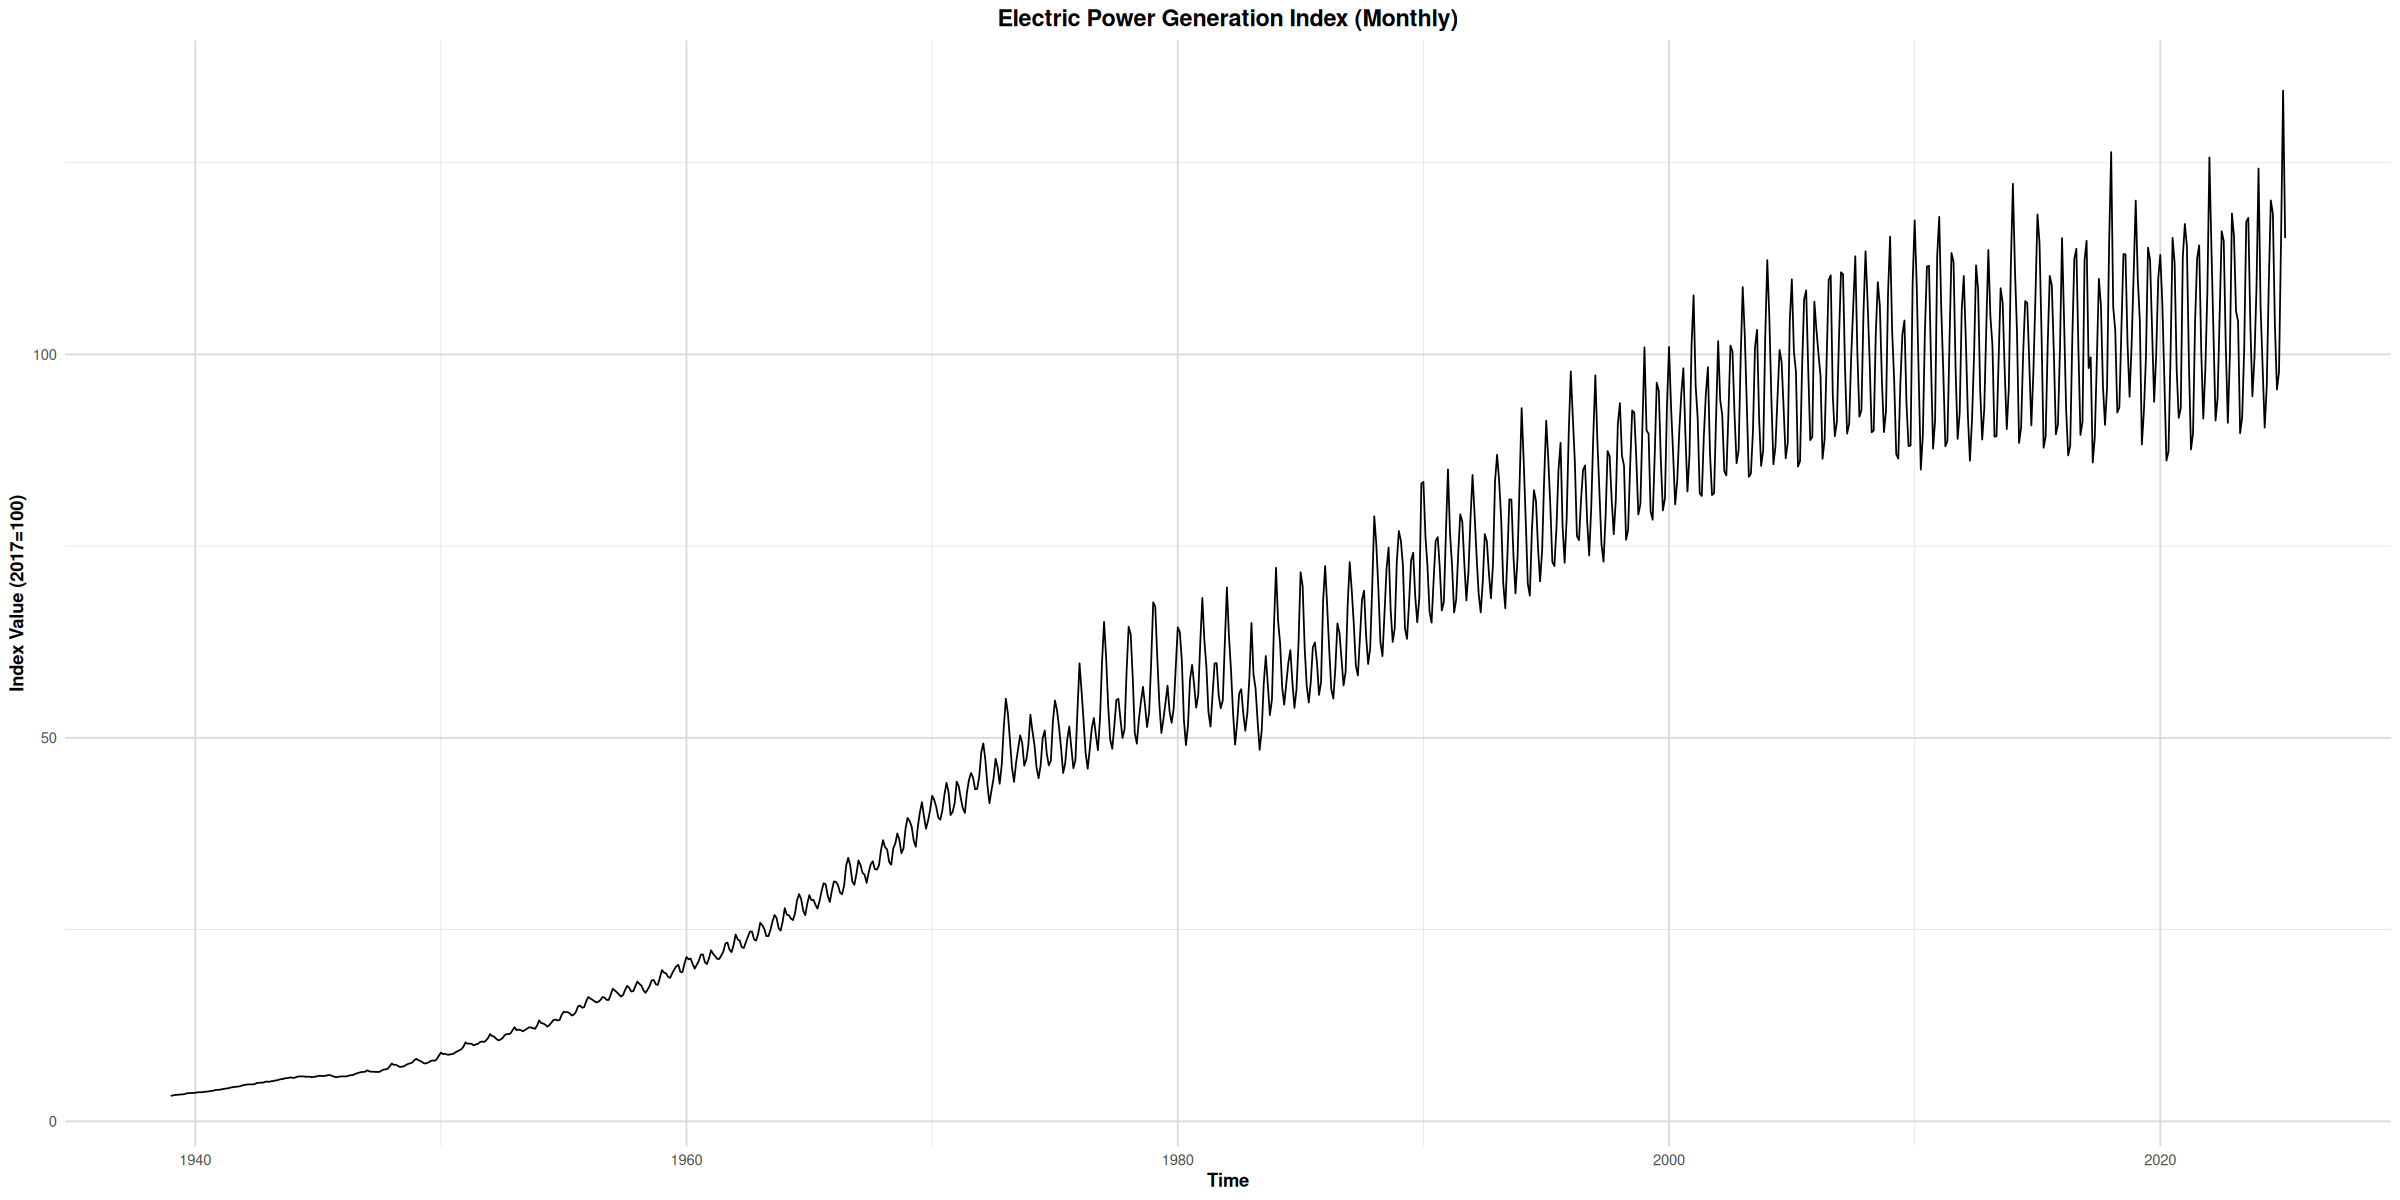

In [9]:
# Create a monthly time series object
monthly_ts <- ts(power_df$value,
  frequency = 12,
  start = c(
    year(min(power_df$date)),
    month(min(power_df$date))
  )
)

# Plot the time series
autoplot(monthly_ts) +
  labs(
    title = "Electric Power Generation Index (Monthly)",
    x = "Time",
    y = "Index Value (2017=100)"
  ) +
  theme_tsa()

Optimal lambda for Box-Cox transformation: -0.3322707 
Using Box-Cox transformation with lambda = -0.3322707 


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Original vs Box-Cox Transformation (λ = -0.3323 )' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Original vs Box-Cox Transformation (λ = -0.3323 )' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Original vs Box-Cox Transformation (λ = -0.3323 )' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Original vs Box-Cox Transformation (λ = -0.3323 )' in 'mbcsToSbcs': dot substituted for <bb>”


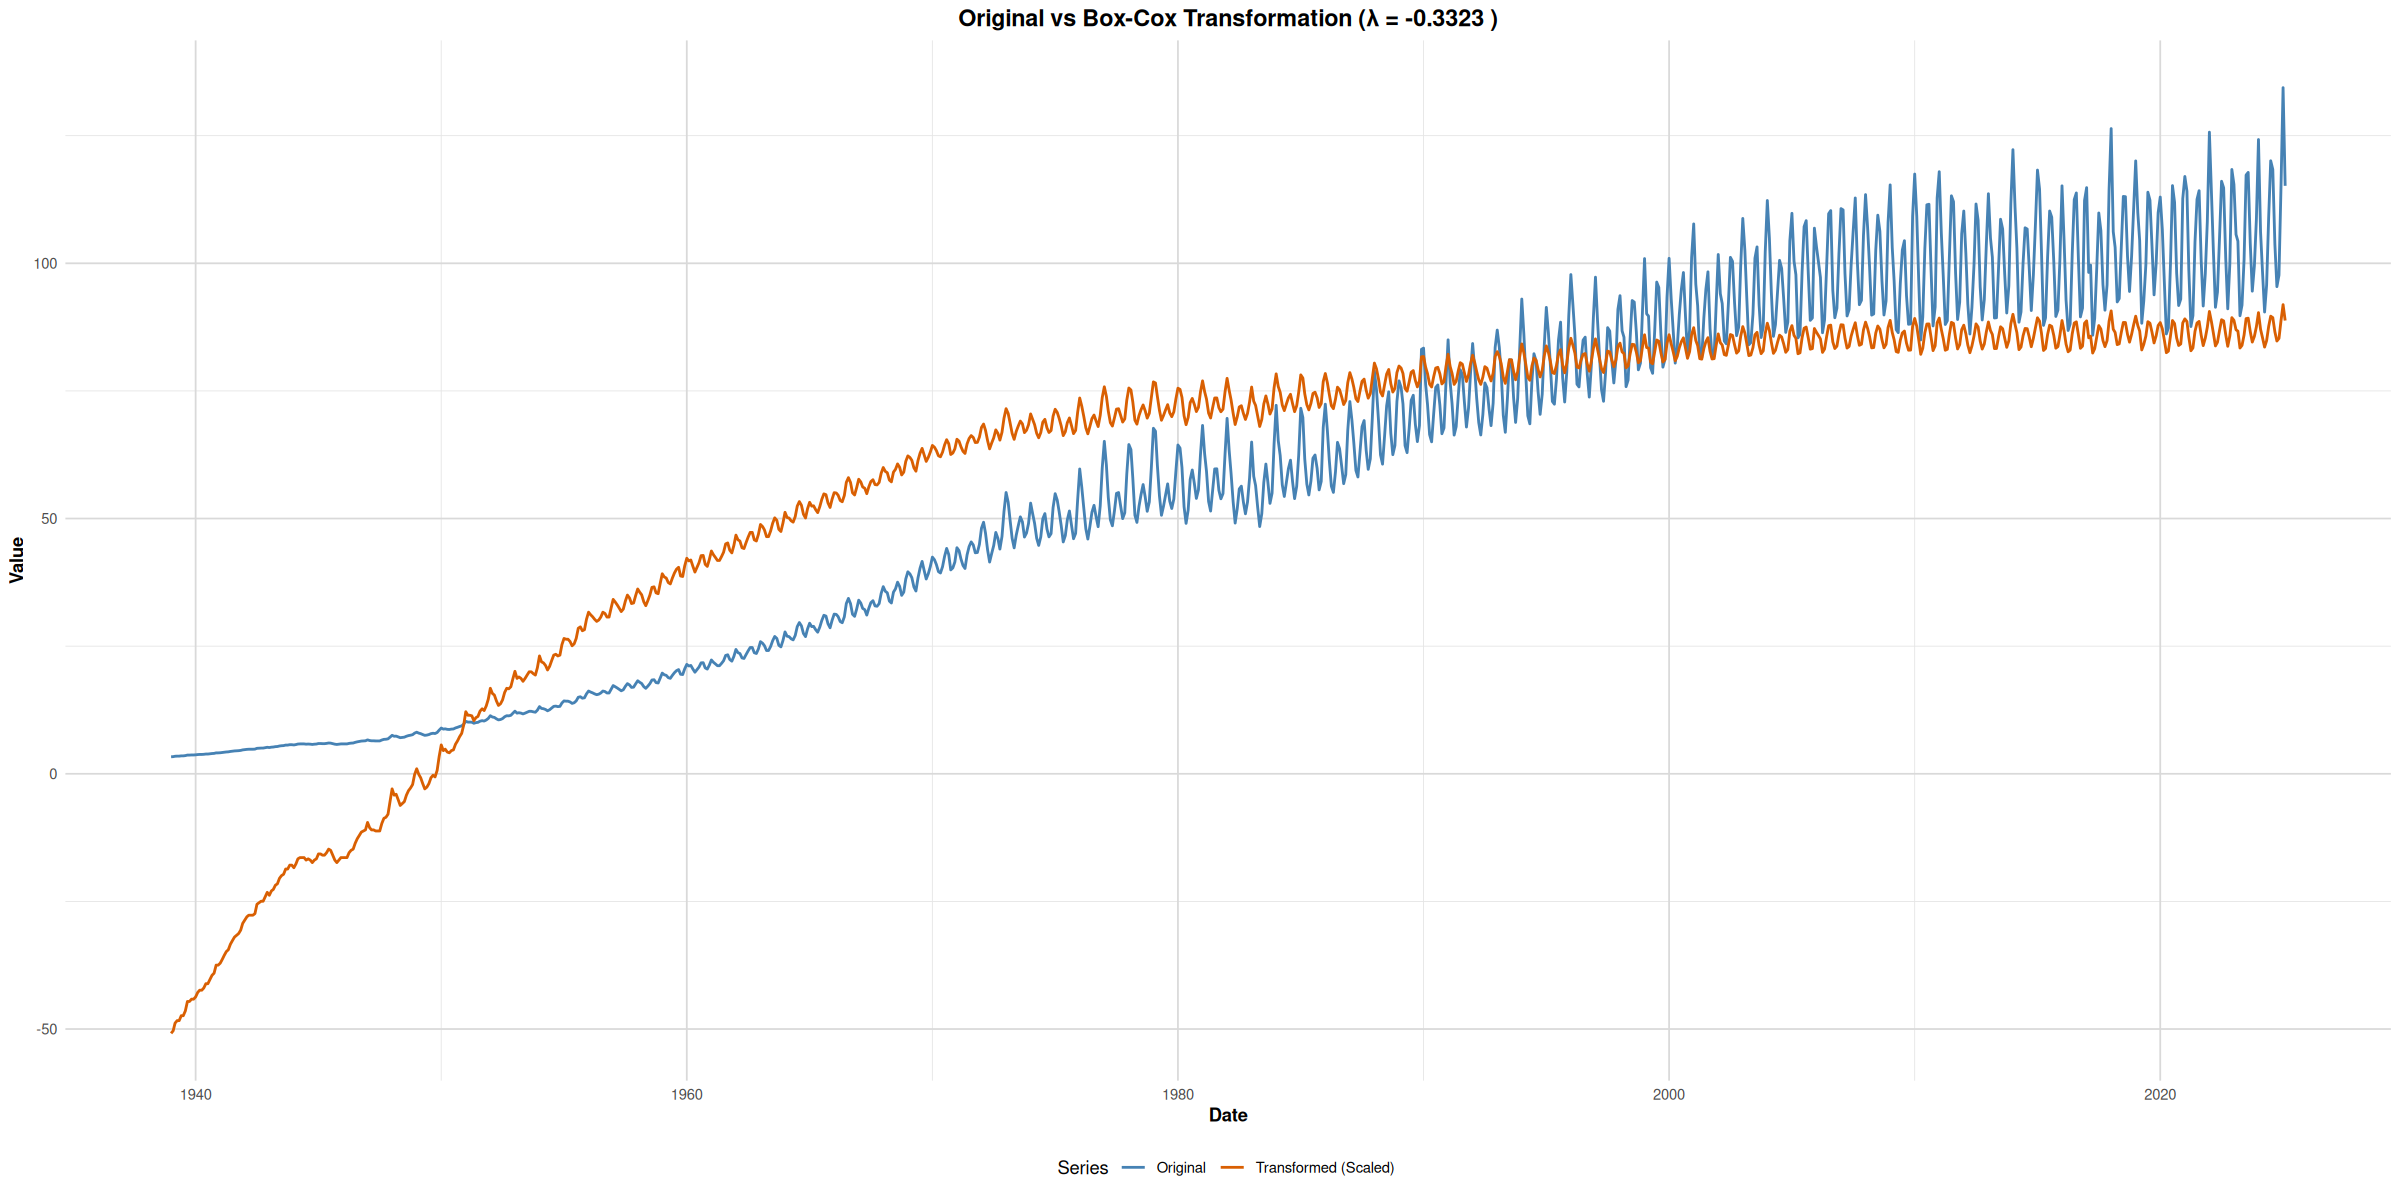

In [10]:
# box-cox transformation

lambda <- BoxCox.lambda(monthly_ts)
cat("Optimal lambda for Box-Cox transformation:", lambda, "\n")
if (abs(lambda) < 0.1) {
    cat("Lambda is close to 0, using log transformation\n")
    transformed_ts <- log(monthly_ts)
    transformation_label <- "Log Transformation"
} else {
    cat("Using Box-Cox transformation with lambda =", lambda, "\n")
    transformed_ts <- BoxCox(monthly_ts, lambda)
    transformation_label <- paste("Box-Cox Transformation (λ =", round(lambda, 4), ")")
}

transformed_df <- data.frame(
    Date = power_df$date,
    Original = as.numeric(monthly_ts),
    Transformed = as.numeric(transformed_ts)
)

# Plot original vs transformed
p_trans <- ggplot(transformed_df, aes(x = Date)) +
    geom_line(aes(y = Original, color = "Original"), linewidth = 0.8) +
    geom_line(aes(
        y = scale(Transformed) * sd(Original) + mean(Original),
        color = "Transformed (Scaled)"
    ), linewidth = 0.8) +
    labs(
        title = paste("Original vs", transformation_label),
        x = "Date", y = "Value",
        color = "Series"
    ) +
    scale_color_manual(values = c("Original" = "#4682B4", "Transformed (Scaled)" = "#D95F02")) +
    theme_tsa()

print(p_trans)


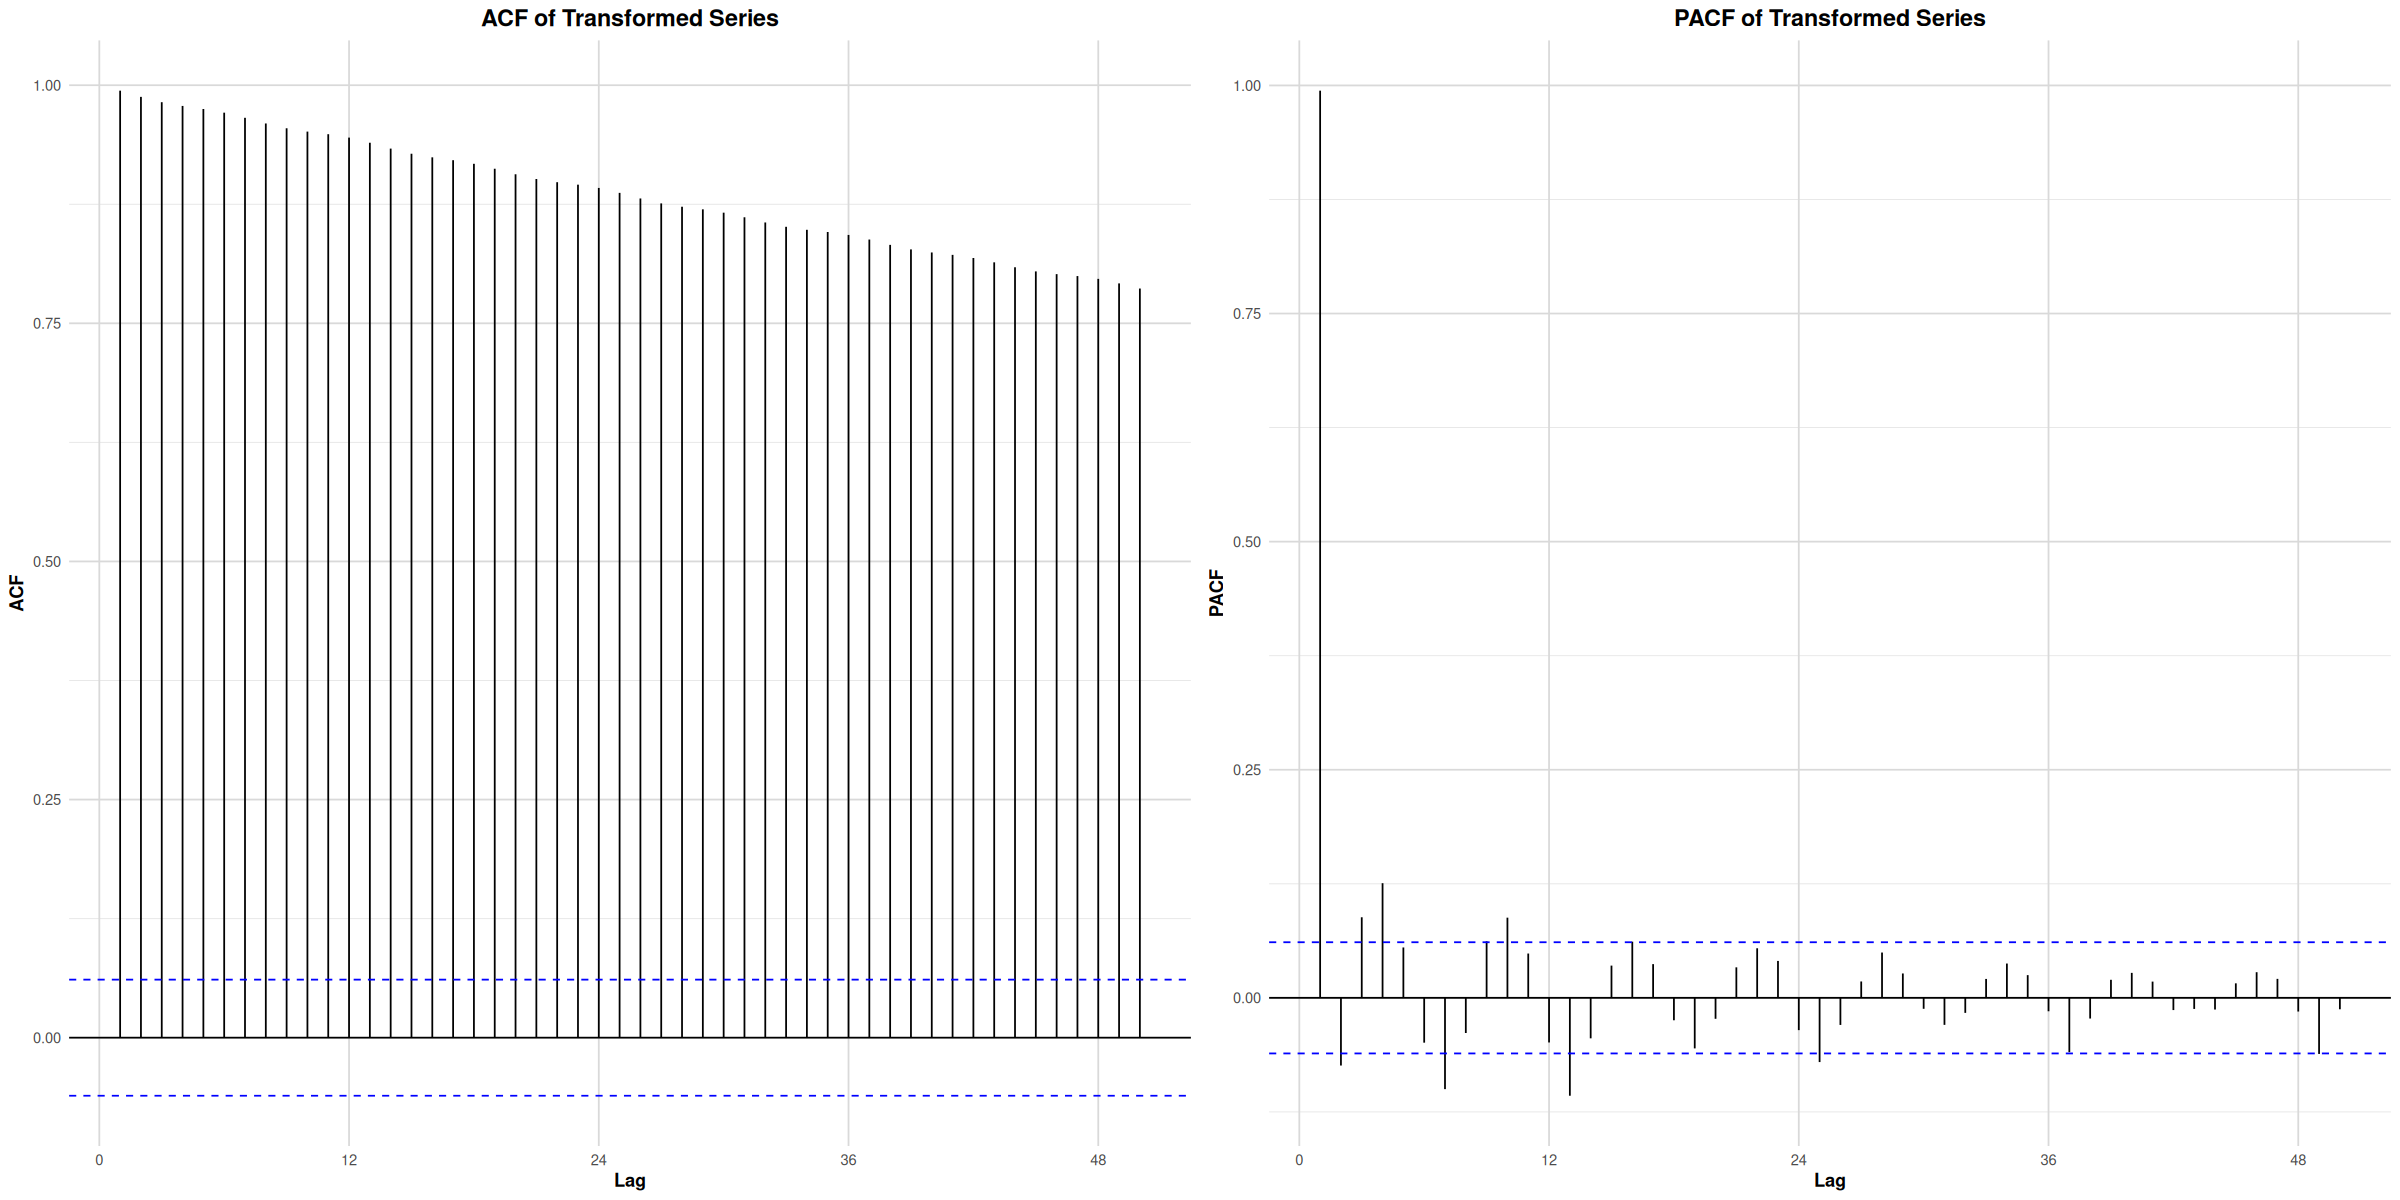

In [11]:
# ACF and PACF plots

p_acf <- ggAcf(transformed_ts, lag = 50) +
  labs(
    title = "ACF of Transformed Series",
    x = "Lag",
    y = "ACF"
  ) +
  theme_tsa()

p_pacf <- ggAcf(transformed_ts, lag = 50, type = "partial") +
    labs(
        title = "PACF of Transformed Series",
        x = "Lag",
        y = "PACF"
    ) +
    theme_tsa()

grid.arrange(p_acf, p_pacf, ncol = 2)

In [12]:
# test for stationarity using ADF test and KPSS test

adf_test <- adf.test(transformed_ts, alternative = "stationary")
kpss_test <- kpss.test(transformed_ts, null = "Trend")

cat("ADF Test for Stationarity:\n")
print(adf_test)

cat("\nKPSS Test for Stationarity:\n")
print(kpss_test)

cat("\nConclusion:\n")
if (adf_test$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in adf.test(transformed_ts, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in kpss.test(transformed_ts, null = "Trend"):
“p-value smaller than printed p-value”


ADF Test for Stationarity:

	Augmented Dickey-Fuller Test

data:  transformed_ts
Dickey-Fuller = -9.5108, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary


KPSS Test for Stationarity:

	KPSS Test for Trend Stationarity

data:  transformed_ts
KPSS Trend = 2.8737, Truncation lag parameter = 7, p-value = 0.01


Conclusion:
ADF test rejects the null hypothesis, series is stationary
KPSS test rejects the null hypothesis, series is non-stationary


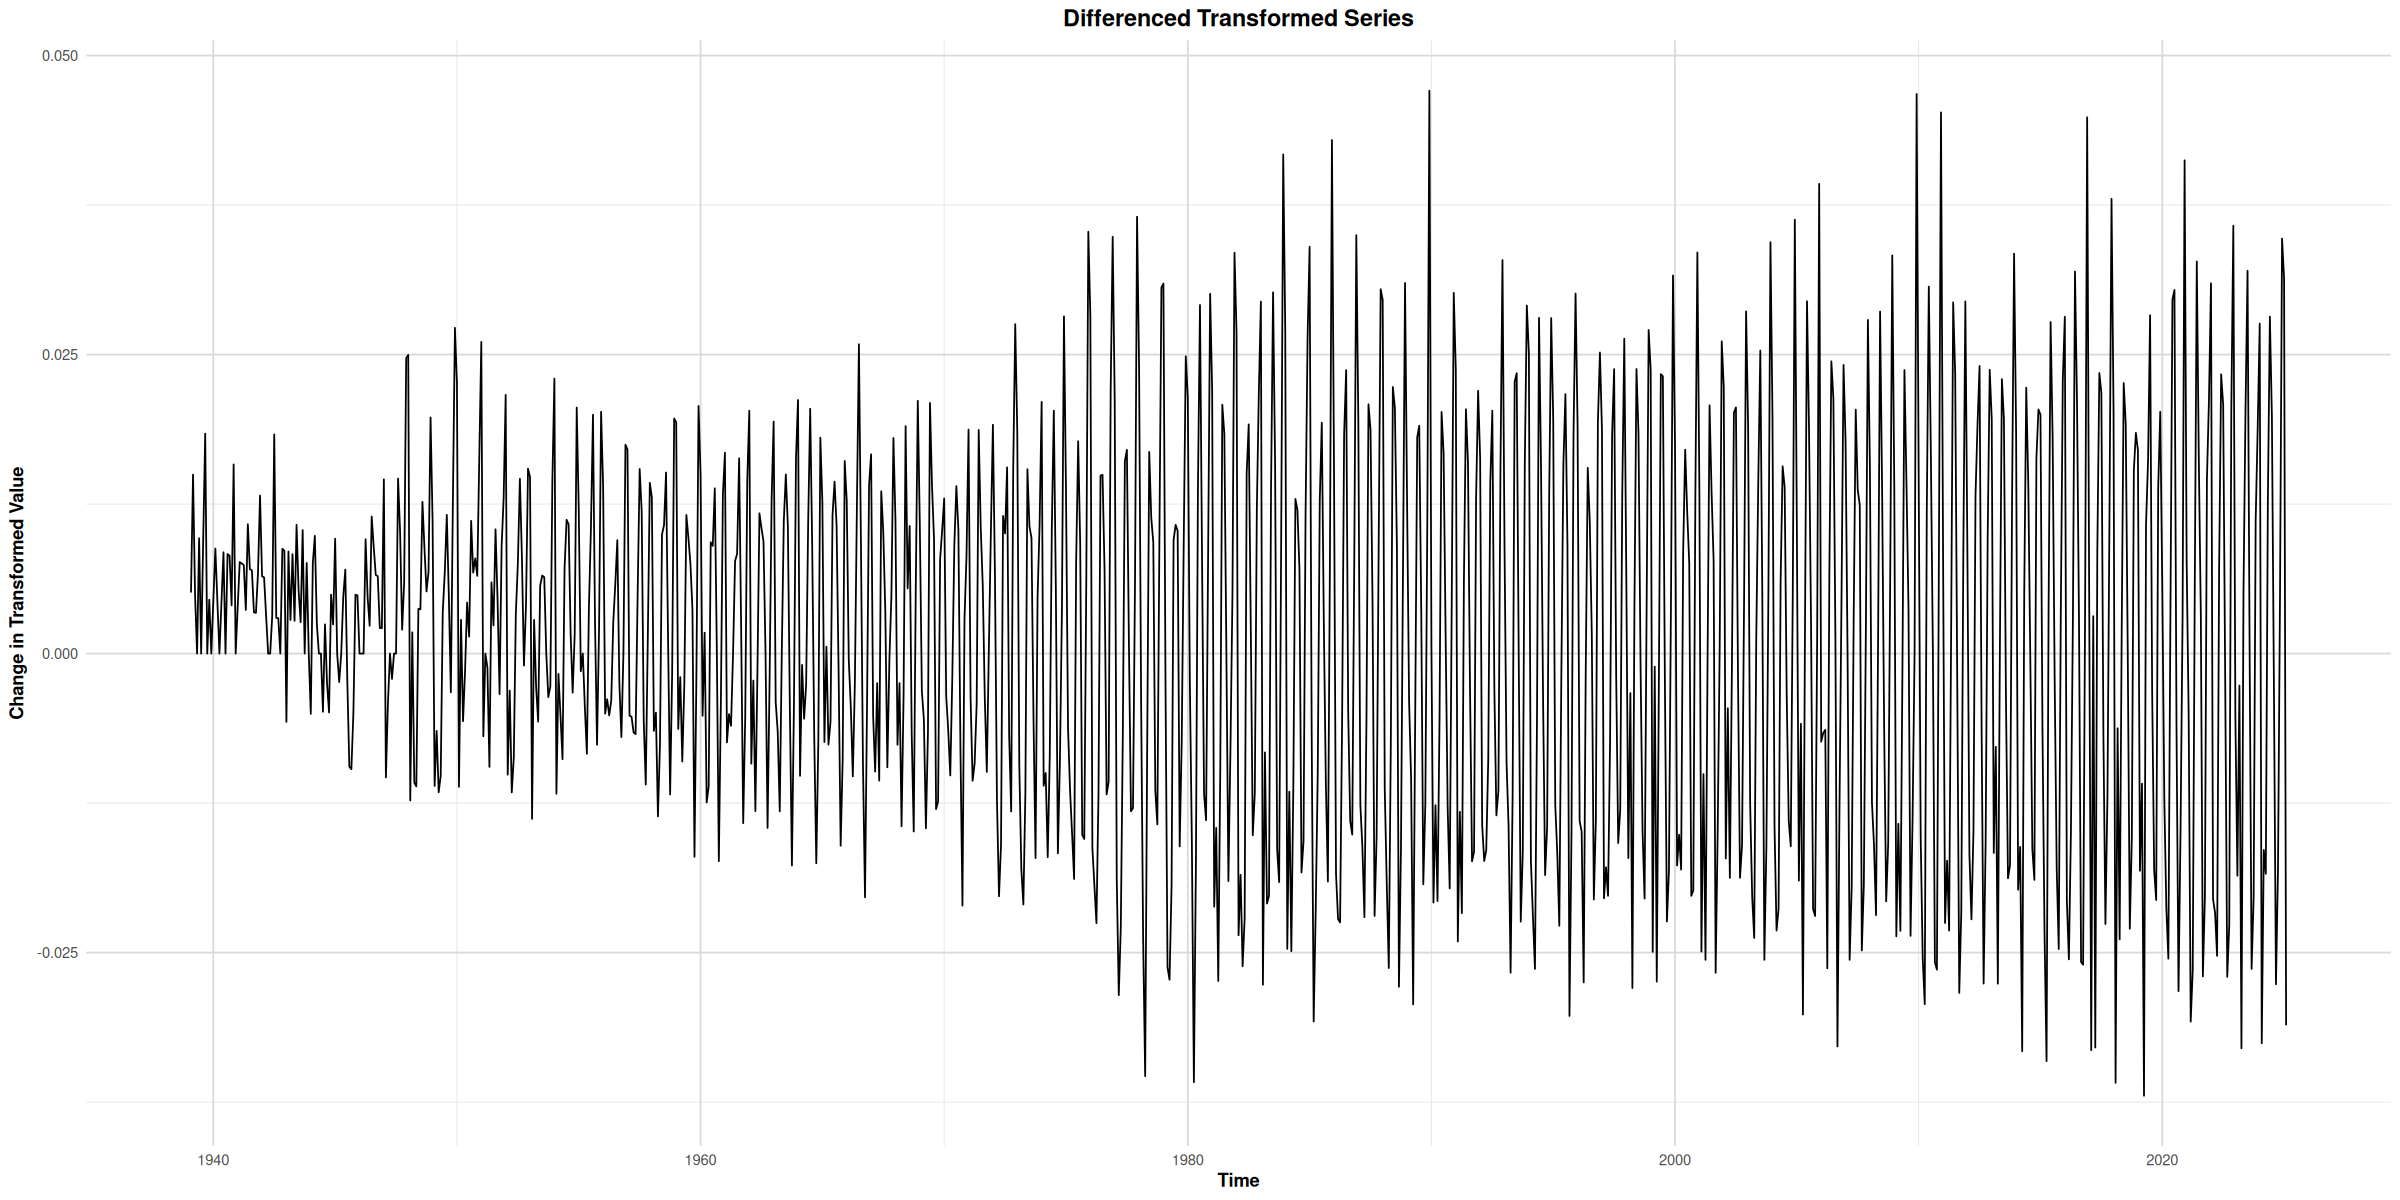

In [13]:
# differencing the series to make it stationary

diff_ts <- diff(transformed_ts)

p_diff <- autoplot(diff_ts) +
    labs(
        title = "Differenced Transformed Series",
        x = "Time", y = "Change in Transformed Value"
    ) +
    theme_tsa()

print(p_diff)

In [14]:
# retesting for stationarity after differencing

adf_test_diff <- adf.test(diff_ts, alternative = "stationary")
kpss_test_diff <- kpss.test(diff_ts, null = "Trend")

cat("ADF Test for Stationarity (After Differencing):\n")
print(adf_test_diff)

cat("\nKPSS Test for Stationarity (After Differencing):\n")
print(kpss_test_diff)

cat("\nConclusion (After Differencing):\n")
if (adf_test_diff$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test_diff$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in adf.test(diff_ts, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in kpss.test(diff_ts, null = "Trend"):
“p-value greater than printed p-value”


ADF Test for Stationarity (After Differencing):

	Augmented Dickey-Fuller Test

data:  diff_ts
Dickey-Fuller = -21.049, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary


KPSS Test for Stationarity (After Differencing):

	KPSS Test for Trend Stationarity

data:  diff_ts
KPSS Trend = 0.095872, Truncation lag parameter = 7, p-value = 0.1


Conclusion (After Differencing):
ADF test rejects the null hypothesis, series is stationary
KPSS test fails to reject the null hypothesis, series is stationary


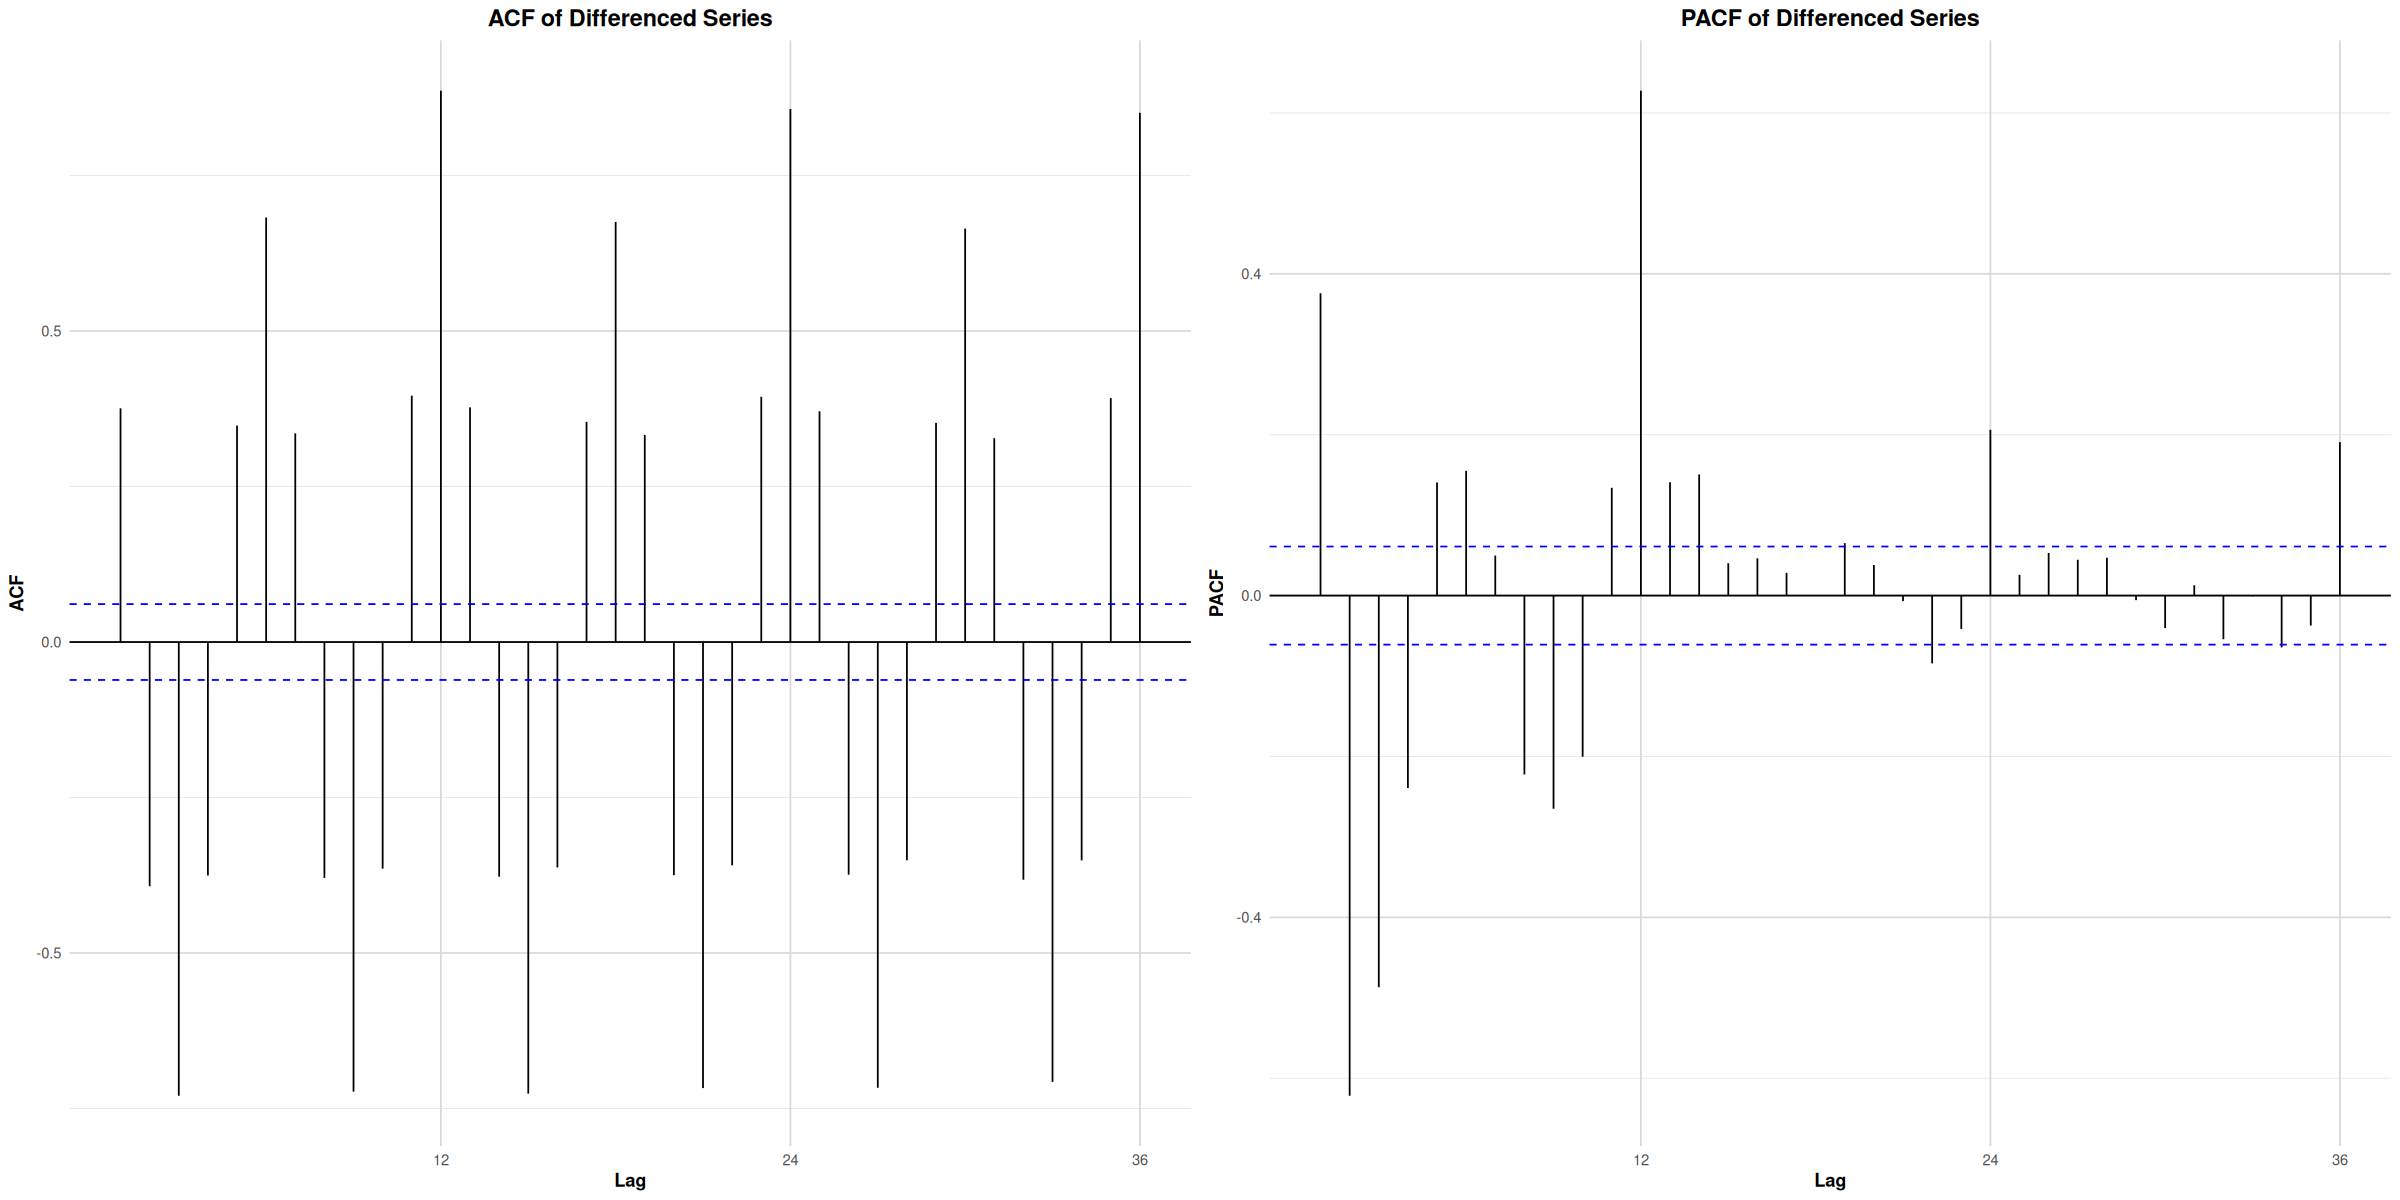

In [15]:
# ACF and PACF plots for differenced series
p_acf_diff <- ggAcf(diff_ts, lag = 36) +
    labs(
        title = "ACF of Differenced Series",
        x = "Lag", y = "ACF"
    ) +
    theme_tsa()

p_pacf_diff <- ggAcf(diff_ts, lag = 36, type = "partial") +
    labs(
        title = "PACF of Differenced Series",
        x = "Lag", y = "PACF"
    ) +
    theme_tsa()

grid.arrange(p_acf_diff, p_pacf_diff, ncol = 2)